### Завдання 1
Використотвуючи датасет з файлу Position_Salaries.csv побудуйте модель поліноміальної регресії.

In [145]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sb

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


In [146]:
ps = pd.read_csv('Position_Salaries.csv')
ps

,Position,Level,Salary
0,Business Analyst,1,45000
1,Junior Consultant,2,50000
2,Senior Consultant,3,60000
3,Manager,4,80000
4,Country Manager,5,110000
5,Region Manager,6,150000
6,Partner,7,200000
7,Senior Partner,8,300000
8,C-level,9,500000
9,CEO,10,1000000


In [147]:
X = ps.Level
y = ps.Salary

#### Linear regression

In [148]:
X2d = X.to_numpy().reshape(-1, 1)
lin_model = LinearRegression()
lin_model.fit(X2d, y)
y_pred = lin_model.predict(X2d)

In [149]:
rmse = np.sqrt(np.mean(np.square(y-y_pred)))
mae = np.mean(abs(y-y_pred))
print(f'Mean absolute error: {mae:.2f}')
print(f'Root mean squred error: {rmse:.2f}')

Mean absolute error: 128454.55
Root mean squred error: 163388.74


#### Polynomial regression

In [150]:
poly_model = np.poly1d(np.polyfit(X, y, 3))

In [151]:
print('Mодель поліноміальної регресії: ')
print(poly_model)

Mодель поліноміальної регресії: 
      3             2
4120 x - 4.855e+04 x + 1.807e+05 x - 1.213e+05


In [160]:
y_pr = poly_model(X)
rmse = np.sqrt(np.mean(np.square(y-y_pr)))
mae = np.mean(abs(y-y_pr))
print(f'Mean absolute error: {mae:.2f}')
print(f'Root mean squred error: {rmse:.2f}')

Mean absolute error: 34790.21
Root mean squred error: 38931.50


#### Візуалізація:

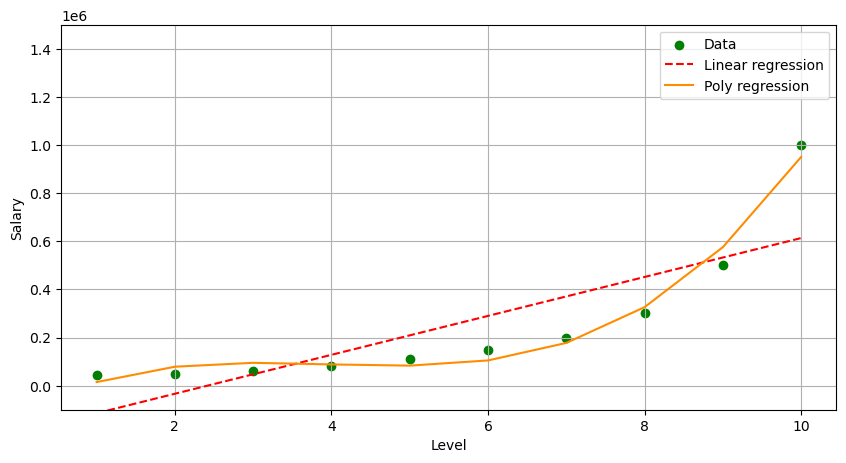

In [162]:

plt.figure(figsize=(10,5))
plt.scatter(X, y, c='g', label = 'Data')
plt.plot(X2d, y_pred, linestyle = '--',color='r', label = 'Linear regression')
plt.plot(X, y_pr, c = 'darkorange', label = 'Poly regression')
plt.xlabel('Level')
plt.ylabel('Salary')
plt.grid()
plt.legend()
plt.ylim (-100000, 1500000) 
plt.show()

#### Показники mae i rmse у поліноміальній регресії набагато нижчі від відповідних показників лінійної регресії. Також візуально видно, що поліноміальна модель добре описує дані, принаймні набагато краще, ніж лінійна. Немає сенсу ускладнювати модель і додавати нові ступені многочлену, бо тоді модель перенавчається і прив'язується до конкретних даних.